In [9]:
import asyncio
import base64
from dataclasses import dataclass
from io import BytesIO
from os import path, listdir
from typing import Tuple

import openai
import matplotlib.pyplot as plt
from PIL import Image
from PIL.ExifTags import GPSTAGS, TAGS
from aio_clients import Http, Options
from aiohttp import ClientTimeout
from geopy import Location
from geopy.geocoders import Nominatim
from geopy.adapters import AioHTTPAdapter

import pandas as pd
from PIL import Image
from IPython.display import display
from pydantic.v1 import BaseSettings


class Setting(BaseSettings):
    astica_api_key: str
    openai_key: str
    base_path: str
    gpt_mode: str = 'gpt-3.5-turbo'
    photographer: str = 'Denis Malin' 
    
    class Config:
        env_file = '.env'
        env_file_encoding = 'utf-8'
        env_nested_delimiter = '__'

setting = Setting()

http = Http(
    option=Options(
        timeout=ClientTimeout(total=60),
    )
)

In [2]:
def batch_split(input_list, batch_size):
    """
    Разделяет список на пакеты (бачи) заданного размера.

    Параметры:
        input_list (list): Исходный список для разделения.
        batch_size (int): Размер пакета (количество элементов в пакете).

    Возвращает:
        list: Список, содержащий пакеты (списки) заданного размера.
    """
    # Инициализируем пустой список для хранения пакетов
    batches = []

    # Переменная для отслеживания текущей позиции в исходном списке
    current_index = 0

    # Разделяем список на пакеты
    while current_index < len(input_list):
        # Извлекаем пакет из исходного списка, начиная с текущей позиции и до batch_size элементов
        batch = input_list[current_index:current_index + batch_size]
        # Добавляем пакет в список пакетов
        batches.append(batch)
        # Переходим к следующей позиции в исходном списке
        current_index += batch_size

    return batches


@dataclass
class ImageDescription:
    coordinates: Tuple[float, float] = None
    camera: str = None
    created: str = None

    location_str: str = None
    location: Location = None
    description: object = None


def get_geotagging(exif):
    if not exif:
        raise ValueError("No EXIF metadata found")

    geotagging = {}
    for (idx, tag) in TAGS.items():
        if tag == 'GPSInfo':
            if idx not in exif:
                raise ValueError("No EXIF geotagging found")

            for (t, value) in GPSTAGS.items():
                if t in exif[idx]:
                    geotagging[value] = exif[idx][t]

    return geotagging


def get_decimal_from_dms(dms, ref):
    degrees = dms[0]
    minutes = dms[1] / 60.0
    seconds = dms[2] / 3600.0

    if ref in ['S', 'W']:
        degrees = -degrees
        minutes = -minutes
        seconds = -seconds

    return round(degrees + minutes + seconds, 5)


def get_coordinates(geotags):
    lat = get_decimal_from_dms(geotags['GPSLatitude'], geotags['GPSLatitudeRef'])
    lon = get_decimal_from_dms(geotags['GPSLongitude'], geotags['GPSLongitudeRef'])

    return (lat, lon)


BY3A4487-CR3_DxO_DeepPRIMEXD.jpg


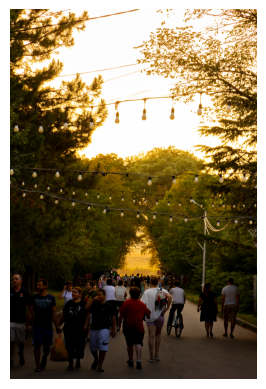

coordinates= (41.74021, 44.74226)
BY3A4512-CR3_DxO_DeepPRIMEXD.jpg


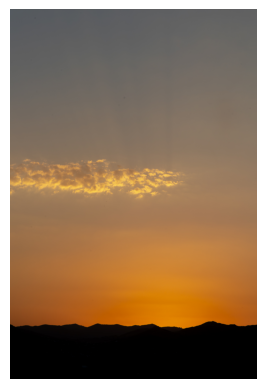

coordinates= (41.74218, 44.73929)
BY3A4537-CR3_DxO_DeepPRIMEXD.jpg


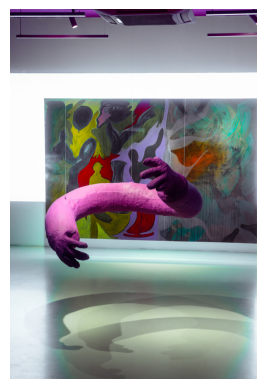

coordinates= (41.70866, 44.78096)
BY3A4533-CR3_DxO_DeepPRIMEXD.jpg


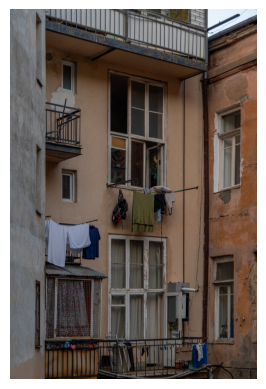

coordinates= (41.70663, 44.78642)
BY3A4515-CR3_DxO_DeepPRIMEXD.jpg
geo tagging error err= No EXIF geotagging found


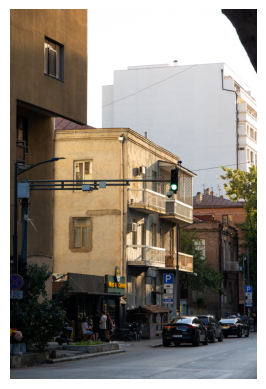

coordinates
> 
location
> Тбилиси


Done


In [21]:
async def get_img_decryption(img: str, base_path: str):
    """Получение описания изображения с помошью asctica"""
    if img in ('.DS_Store',):
        return None, None

    print(img)

    img_data = ImageDescription()

    p_image = Image.open(path.join(base_path, img))
    exif = p_image._getexif()

    coordinates = None
    try:
        geotags = get_geotagging(exif)
        coordinates = get_coordinates(geotags)
    except Exception as ex:
        print('geo tagging error err=', ex)

    # p_img.save('test.jpg')
    buffered = BytesIO()

    new_width = p_image.width // 4
    new_height = p_image.height // 4
    resized_image = p_image.resize((new_width, new_height))
    resized_image.save(buffered, format="jpeg")
    img_str = base64.b64encode(buffered.getvalue())

    img_data.coordinates = coordinates
    img_data.camera = exif[271]
    img_data.created = exif[36868]

    plt.imshow(p_image)
    plt.axis('off')
    plt.show()
    if not coordinates:
        coordinates = input('coordinates\n>')
        if coordinates:
            coordinates = tuple(float(i) for i in coordinates.split(', '))

    if coordinates:
        print('coordinates=', coordinates)
        async with Nominatim(
                user_agent="github.com/skar404/wirestock-auto/develop",
                adapter_factory=AioHTTPAdapter,
                timeout=60,
        ) as geolocator:
            img_data.location = await geolocator.reverse(coordinates, language='en')

    if not img_data.location:
        img_data.location_str = input('location\n>')

    r = await http.post(
        path="https://vision.astica.ai/describe",
        data={
            "tkn": setting.astica_api_key,
            "modelVersion": "2.1_full",
            "visionParams": "gpt",
            "input": f"data:image/jpeg;base64,{img_str.decode('utf-8')}" if img else url
        }
    )
    img_data.description = r.json

    if r.code != 200 or not img_data.description.get('caption_GPTS'):
        print('error astica', img_data.description)
        raise

    data = "Твоя задача присылать рецензию на фотографии которое прислала пользовательл для сервиса wirestock, правила:\n" \
           "- Пищи твое только рецензию фотографии\n" \
           "- В рецензии напиши локацию где сделано фото\n" \
           "- При написании учитывай  дату и время когда сделано фото\n" \
           "- Пиши только очень краткие рецензию" \
           "- лимит рецензию 500 символов\n" \
           "- На английском языке\n" \
           "- Учитывай данные пользователя\n" \
           "Принимай тольок эти поля: \n" \
           "- Локация\n" \
           "- Дату и время\n" \
           "- Тестовая информация о фото\n"
    openai.api_key = setting.openai_key

    response = await openai.ChatCompletion.acreate(
        model=setting.gpt_mode,
        messages=[
            {
                'role': 'system',
                'content': data,
            },
            {
                'role': 'user',
                'content': f"Локация: {img_data.location.address if img_data.location else img_data.location_str}\n"
                           f"{'Дату и время: ' + img_data.created if img_data.created else ''}\n"
                           f"Тестовая информация о фото: {img_data.description['caption_GPTS']}"
            }
        ],
    )
    return p_image, response['choices'][0]['message']['content']


openai.api_key = setting.openai_key

img_name = ''

# plt.imshow(p_image)
# plt.axis('off') 
# plt.show()

data = []
# for img_name in batch_split(
#     listdir(setting.base_path),
#     5,
# ):  
base_path = setting.base_path
for img_name in batch_split("""BY3A4487-CR3_DxO_DeepPRIMEXD.jpg
BY3A4512-CR3_DxO_DeepPRIMEXD.jpg
BY3A4537-CR3_DxO_DeepPRIMEXD.jpg
BY3A4533-CR3_DxO_DeepPRIMEXD.jpg
BY3A4515-CR3_DxO_DeepPRIMEXD.jpg""".split('\n'), 5):
    result = await asyncio.gather(*[get_img_decryption(img=i, base_path=base_path) for i in img_name])

    for i in result:
        data.append(i)

print('Done')

In [20]:
print(data)

[]


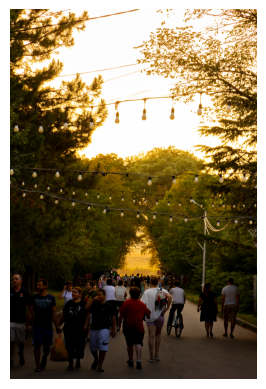

Review: This warm, serene evening scene near Lisi Lake, Tbilisi, on August 5, 2023 is beautifully captured. The setting sun's hues juxtaposing against the group of people, their varied clothing hinting at diversity, creates an evocative image. The deep blue sky with an impending sunset evokes peacefulness and relaxation, with the street lamps illuminating the scene perfectly. Denis Malin


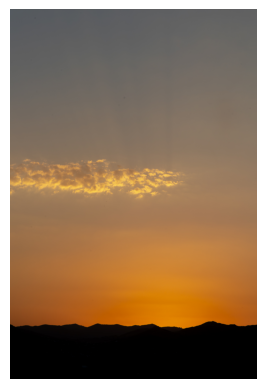

This image from Lisi Recreation, Tbilisi, Georgia on August 5, 2023, poignantly captures the tranquility of sunset time. The striking mix of fiery reds, oranges, cool blues, and greys in the sky, enhanced by the golden sun rays and silhouetted mountains, creates a breathtaking, serene scenery. Ideal for nature and time enthusiasts seeking to encapsulate the evening's peace and beauty. Denis Malin


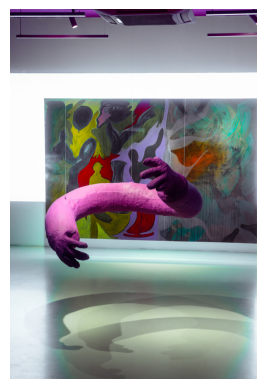

Image review: This photo taken in 2023 at Petre Melikishvili Avenue, Tbilisi, Georgia depicts an artistic, close-up shot of a vibrant purple sculpture of a gloved hand. The backdrop is a colorful wall with a small purple object and a unique black-white pattern on the ceiling. What adds intrigue is a subtle human shadow against a white surface. With its strong artistic appeal and serene ambiance, it excellently encapsulates the essence of indoor settings. Denis Malin


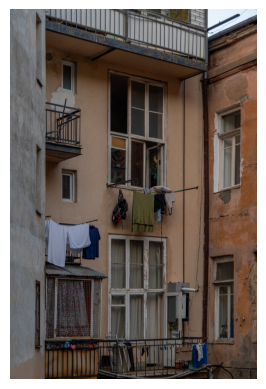

Review: This urban scene captures a moment of everyday life in Tbilisi, Georgia - specifically at the apartment complex near Tbilisi Concert Hall. A meticulously composed photograph showing a building facade, a balcony with laundry hanging out to dry, and desaturated aesthetic of grey and muted green, documented in August 2023. The framing through windows adds an element of voyeurism and curiosity, inviting viewers to imagine city life within these walls. Denis Malin


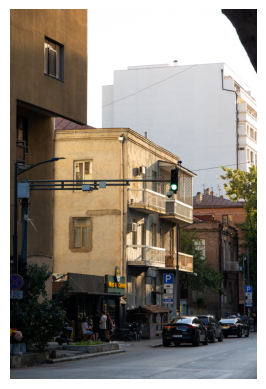

Your photograph perfectly captures the everyday hustle of Tbilisi, with the street light creating an interesting play of shadows. The timing (2023:08:06 18:48:51) accentuates the juxtaposition of the day's end and the city's continuous movement. The vibrancy of colors and elements like the street sign, traffic light and cars add a dynamic layer to this urban image. The clear sky forms a perfect contrast to the busy street life below. Denis Malin


In [24]:
mg_list = []
des_list = []

for i in data:
    if isinstance(i, Exception):
        continue
    _img, _des = i

    if setting.gpt_mode != 'gpt-4':
        response = await openai.ChatCompletion.acreate(
            model="gpt-3.5-turbo",
            messages=[
                {
                    'role': 'system',
                    'content': "сократи текст пользователя до 500 знаков, можон удалять предложения"
                },
                {
                    'role': 'user',
                    'content': _des
                }
            ],
        )
        _des = response['choices'][0]['message']['content']
    
    try:
        plt.imshow(_img)
        plt.axis('off')  # Отключение осей координат
        plt.show()
        print(_des, setting.photographer)
    except:
        print('error')

In [8]:
await http.close()